In [2]:
#####################################################
## @author : Yash Sharma
## @email: yashuvats.42@gmail.com
#####################################################

In [3]:
#### importing necessary modules and libraries
from Model import *
from SilenceRemover import *
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torchaudio
from sklearn.model_selection import train_test_split
import os
import sys
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from datasets import load_dataset, Audio
from dataclasses import dataclass
from datasets import load_dataset, load_metric, load_from_disk, disable_caching
from transformers.file_utils import ModelOutput
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch
from transformers import AutoFeatureExtractor, TrainingArguments, AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor, EvalPrediction, Trainer
import numpy as np
from typing import Any, Dict, Union, Tuple
import torch
from packaging import version
from torch import nn
from huggingface_hub import login
from torch import optim
import random
from torch.autograd import Variable
import multiprocessing
from gaussianSmooth import *

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
nc = 11 # Number of language classes 
n_epoch = 200 # Number of epochs
look_back1 = 21 # range
IP_dim = 49*look_back1 # number of input dimension
path = "/Users/yash/Desktop/MTP-2k23-24"
model_path = os.path.join(path,"model_xVector.pth")
silencedAndOneSecondAudio_size = 16000
hop_size = 0.25 # in sec
window_size = 16000
hop_length_seconds = 0.25  # Desired hop length in seconds
audio_path = "/Users/yash/Desktop/MTP-2k23-24/Wav2vec-codes/codemixed_eng_hin.wav"

Device: cpu


In [5]:
### Intializing models
## for wave2vec2
model_name_or_path = "yashcode00/wav2vec2-large-xlsr-indian-language-classification-featureExtractor"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
model_wave2vec2 = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)
target_sampling_rate = processor.feature_extractor.sampling_rate

target_sampling_rate

### for x-vector
model_xVector = X_vector(IP_dim, nc)
# model.cuda()
optimizer =  optim.Adam(model_xVector.parameters(), lr=0.0001, weight_decay=5e-5, betas=(0.9, 0.98), eps=1e-9)
loss_lang = torch.nn.CrossEntropyLoss()  # cross entropy loss function for the softmax output
#####for deterministic output set manual_seed ##############
manual_seed = random.randint(1,10000) #randomly seeding
random.seed(manual_seed)
torch.manual_seed(manual_seed)

if "model_xVector.pth" in os.listdir(path):
    model_xVector.load_state_dict(torch.load(model_path), strict=False)
else:
    print("No, TDNN saved model found, Aborting!")
    exit(0)

In [6]:
label_list  = ['asm', 'ben', 'eng', 'guj', 'hin', 'kan', 'mal', 'mar', 'odi', 'tam', 'tel']
lang2id = {'asm': 0, 'ben': 1, 'eng': 2, 'guj': 3, 'hin': 4, 'kan': 5, 'mal': 6, 'mar': 7, 'odi': 8, 'tam': 9, 'tel': 10}
id2lang = {0: 'asm', 1: 'ben', 2: 'eng', 3: 'guj', 4: 'hin', 5: 'kan', 6: 'mal', 7: 'mar', 8: 'odi', 9: 'tam', 10: 'tel'}
### defining mask for the hindi and english language
mask = np.array([0,0,1,0,1,0,0,0,0,0,0])
print("Mask for binary (Hin/Eng) classification: ",mask)

Mask for binary (Hin/Eng) classification:  [0 0 1 0 1 0 0 0 0 0 0]


In [7]:
def preProcessSpeech(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech_array = torch.frombuffer(RemoveSilence(path),dtype=torch.float32)
    speech_array = resampler(speech_array).squeeze().numpy()
    return speech_array

## function to store the hidden feature representation from the last layer of wave2vec2
def getHiddenFeatures(speech_array):
    silencedAndOneSecondAudio = speech_array
    # print(len(silencedAndOneSecondAudio))
    preds = []
    # Predict for the silencedAndOneSecondAudio

    audio_length = len(silencedAndOneSecondAudio)
    if audio_length < silencedAndOneSecondAudio_size:
        # If the audio is shorter, pad it with a dummy value (0 in this case)
        pad_length = silencedAndOneSecondAudio_size - audio_length
        # print(torch.zeros(pad_length))
        silencedAndOneSecondAudio = torch.cat((torch.Tensor(silencedAndOneSecondAudio), torch.zeros(pad_length)), dim=0)
    elif audio_length > silencedAndOneSecondAudio_size:
        # If the audio is longer, truncate it to the target length
        silencedAndOneSecondAudio = silencedAndOneSecondAudio[:silencedAndOneSecondAudio_size]

    # print("after size: ",len(silencedAndOneSecondAudio))
    # print("padded: ",silencedAndOneSecondAudio)

    # Predict for the silencedAndOneSecondAudio
    features = processor(silencedAndOneSecondAudio, sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)
    input_values = features.input_values.to(device)

    # Generate the attention mask
    attention_mask = torch.ones_like(input_values)  # Default all ones
    attention_mask[0][audio_length:] = 0  # Set zeros for the padded part
    attention_mask = attention_mask.to(device)  # Add batch dimension and move to device

    # torch.set_printoptions(profile="full")
    # print("Input: ",input_values)
    # print("Attention: ",attention_mask)
    try:
        with torch.no_grad():
            # Pass attention_mask to the model to prevent attending to padded values
            hidden_features = model_wave2vec2.extract_hidden_states(input_values)
    except Exception as err:
        print(f"Error -> {err} \nSKIPPED! Input Length was: {len(silencedAndOneSecondAudio)} and features len was : {len(input_values)}")
    # Return the overall majority prediction
    # print("Hiden features size: ",hidden_features.shape)
    return hidden_features

def inputTDNN(hidden_features):
    #### Function to return data (vector) and target label of a csv (MFCC features) file
    X = hidden_features.reshape(1024,-1)
    Xdata1 = []
    for i in range(0,len(X)-look_back1,1):    #High resolution low context        
        a = X[i:(i+look_back1),:]  
        b = [k for l in a for k in l]      #unpacking nested list(list of list) to list
        Xdata1.append(b)
    Xdata1 = np.array(Xdata1)    
    Xdata1 = torch.from_numpy(Xdata1).float() 
    return Xdata1

In [8]:
S0, S1 = None, None

In [41]:
def pipeline(path):
    ## Step 1: preprocees the audio by removing silence
    x = preProcessSpeech(path)
    ## Now, we will just bbreak this audio into multiple overlapping windows 
    # Calculate the hop size in samples
    hop_size = int(hop_length_seconds * target_sampling_rate)  # Adjust 'sample_rate' as needed

    # Generate overlapping frames
    frames = [x[i:i+window_size] for i in range(0, len(x) - window_size + 1, hop_size)]
    S0 = []
    S1 = []
    for frame in tqdm(frames):
        ## Step 2: get the hidden featrue for the processed output
        x = getHiddenFeatures(frame)
        ### Step 3: get the output of TDNN for both eng and hindi
        XX_val = inputTDNN(x)
        XX_val = torch.unsqueeze(XX_val, 1)
        X_val = np.swapaxes(XX_val, 0, 1)
        X_val = Variable(X_val, requires_grad=False)
        model_xVector.eval()  # Set the model to evaluation mode
        val_lang_op = model_xVector.forward(X_val)
        # print(val_lang_op)
        # print("Output feature Size: ", val_lang_op.shape)
        val_lang_op = val_lang_op.detach().cpu().numpy()[0]
        ## Step 4: mask the output for all languauge except eng and hindi
        val_lang_op = mask*val_lang_op
        val_lang_op = val_lang_op[np.nonzero(val_lang_op)]
        S0.append(val_lang_op[0])
        S1.append(val_lang_op[1])
    return np.array(S0), np.array(S1)


In [42]:
# if __name__ == '__main__':
#     def pipeline(path):
#         x = preProcessSpeech(path)
#         hop_size = int(hop_length_seconds * target_sampling_rate)
#         frames = [x[i:i+window_size] for i in range(0, len(x) - window_size + 1, hop_size)]

#         # Create a Pool of worker processes
#         num_workers = multiprocessing.cpu_count()
#         with multiprocessing.Pool(num_workers) as pool:
#             results = pool.map(process_frame, frames)

#         S0 = [result[0] for result in results]
#         S1 = [result[1] for result in results]

#         return np.array(S0), np.array(S1)


# def process_frame(frame):
#     # Step 2: Get the hidden feature for the processed output
#     x = getHiddenFeatures(frame)
#     # Step 3: Get the output of TDNN for both English and Hindi
#     XX_val = inputTDNN(x)
#     XX_val = torch.unsqueeze(XX_val, 1)
#     X_val = np.swapaxes(XX_val, 0, 1)
#     X_val = Variable(X_val, requires_grad=False)
#     model_xVector.eval()  # Set the model to evaluation mode
#     val_lang_op = model_xVector.forward(X_val)
#     val_lang_op = val_lang_op.detach().cpu().numpy()[0]
#     # Step 4: Mask the output for all languages except English and Hindi
#     val_lang_op = mask * val_lang_op
#     val_lang_op = val_lang_op[np.nonzero(val_lang_op)]
#     return val_lang_op

In [43]:
if "data.npz" in os.listdir("/Users/yash/Desktop/MTP-2k23-24/Wav2vec-codes/"):
    print("Loading cached version!")
    # Load the arrays from the NPZ file
    loaded_data = np.load("data.npz")
    S0 = loaded_data["s0"]
    S1 = loaded_data["s1"]
else:
    print("Saved Version Not Found, calclating!")
    S0, S1 = pipeline(audio_path)
S0, S1 = pipeline(audio_path)
print("English/ S0 shape: ", S0.shape)
print("Hindi/ S1 shape: ", S1.shape)
# Save s0 and s1 to an NPZ file
np.savez("data.npz", s0=S0, s1=S1)

Loading cached version!


100%|██████████| 200/200 [16:13<00:00,  4.87s/it]

English/ S0 shape:  (200,)
Hindi/ S1 shape:  (200,)


In [44]:
window_size = 21  # A good starting value for the window size
sigma = 0.003*21  # A reasonable starting value for sigma

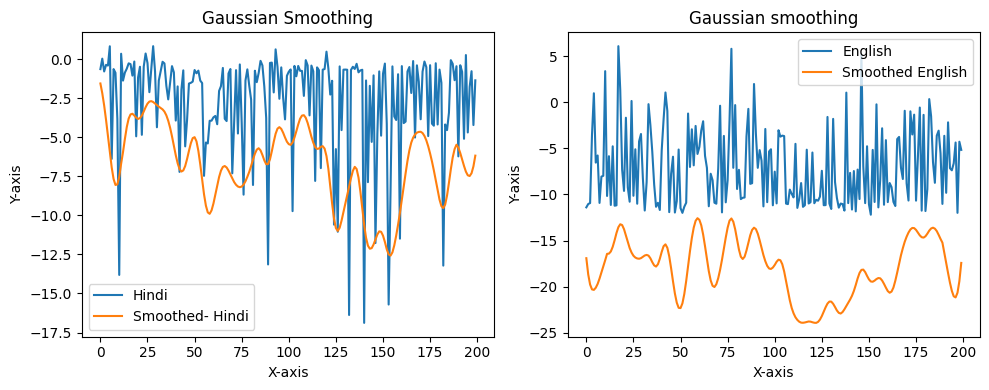

In [45]:
def visualizeSmoothing(S0, S1):
    # Create a figure with two subplots (side by side)
    plt.figure(figsize=(10, 4))

    # Plot the original vectors on the first subplot
    plt.subplot(1, 2, 1)
    plt.plot(S0, label="Hindi")
    plt.plot(gauss_smoothen(S0, sigma, window_size), label="Smoothed- Hindi")
    plt.title("Gaussian Smoothing")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()

    # Plot the smoothed vectors on the second subplot
    plt.subplot(1, 2, 2)
    plt.plot(S1, label="English")
    plt.plot(gauss_smoothen(S1, sigma, window_size), label="Smoothed English")
    plt.title("Gaussian smoothing")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()

    # Adjust layout to avoid overlapping labels
    plt.tight_layout()

    # Show the plot
    plt.show()
visualizeSmoothing(S0, S1)

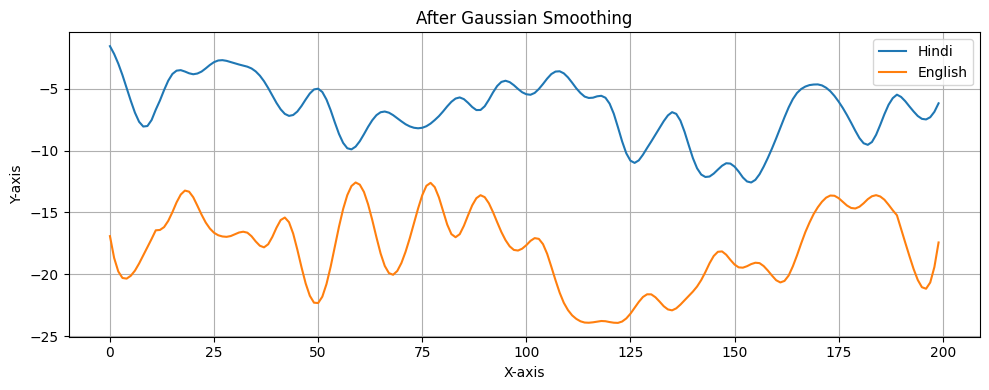

In [46]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(10, 4))

# Plot the original vectors on the first subplot
plt.plot(gauss_smoothen(S0, sigma, window_size), label="Hindi")
plt.plot(gauss_smoothen(S1, sigma, window_size), label="English")
plt.title("After Gaussian Smoothing")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
# Adjust layout to avoid overlapping labels
plt.tight_layout()
plt.grid()
# Show the plot
plt.show()

#### Visualize the real and calculated CP with labels

      Label: Codemixed Hindi English

Duration of the speech:  25.0


/var/folders/hw/9s_jqm8d44nfvywkt4hkr0qm0000gn/T/ipykernel_78287/1525721892.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(cp*16000, 0, 'ro',color='blue', marker='o', markersize=8, label='GCP' if i == 0 else "")
/var/folders/hw/9s_jqm8d44nfvywkt4hkr0qm0000gn/T/ipykernel_78287/1525721892.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(cp*16000, 0, 'ro',color='blue', marker='o', markersize=8, label='GCP' if i == 0 else "")


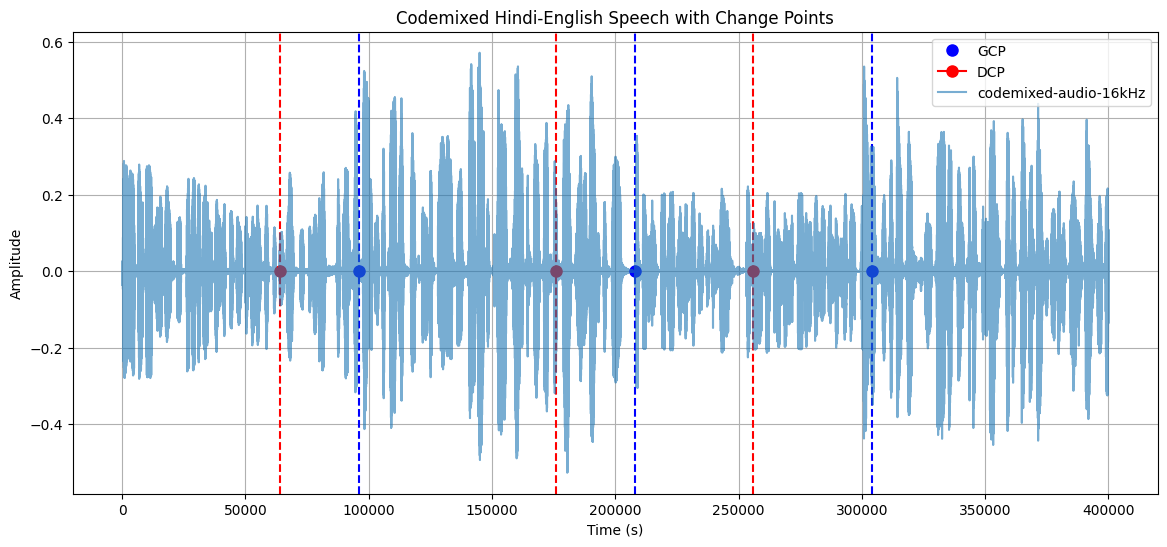

Original sampling Rate:  8000
After resampling: duration-> 50.0
Before  (200000,) 
After:  (400000,)


In [47]:
def plotCP(audio_path, gcp, dcp):
    print(f"      Label: Codemixed Hindi English")
    print()
    gcp = np.array(gcp)
    dcp = np.array(dcp)
    speech, sr = torchaudio.load(audio_path)
    speech = speech[0].numpy().squeeze()
    print("Duration of the speech: ",len(speech)/sr)
    # Resample the audio signal to a target sampling rate of 16,000 Hz
    speech16k = librosa.resample(speech, orig_sr=sr, target_sr=16000)

    # Create a time vector in seconds
    time = np.arange(0, len(speech)) / sr

    plt.figure(figsize=(14, 6))
    i=0
    # Add ground truth change points as circles
    for cp in gcp:
        plt.plot(cp*16000, 0, 'ro',color='blue', marker='o', markersize=8, label='GCP' if i == 0 else "")
        plt.axvline(x=cp * 16000, color='blue', linestyle='--')
        i=1

    i=0
    # Add detected change points as vertical dashed lines
    for cp in dcp:
        plt.plot(cp*16000, 0, marker='o',color='red',markersize=8, label='DCP' if i == 0 else "")
        plt.axvline(x=cp * 16000, color='red' ,linestyle='--')
        i =1

    # Set plot labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Codemixed Hindi-English Speech with Change Points')

    ## show audio
    plt.plot(speech16k, label= 'codemixed-audio-16kHz', alpha = 0.6)

    # Show the plot
    plt.legend(loc = 1)
    plt.grid()
    plt.show()

    print("Original sampling Rate: ",sr)

    print("After resampling: duration->",len(speech16k)/sr)
    print("Before ",speech.shape,"\nAfter: ",speech16k.shape)
    return ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sr)

gcp = [6.0, 13.0, 19.0]  # Ground truth change points in seconds
dcp = [4.0, 11.0, 16.0]  # Detected change points in seconds
plotCP(audio_path, gcp, dcp)

### Now, we will use the technique of languauge diarization to find the change points following the research paper

In [48]:
def diarize(S0,S1):
    ## Step 1: gaussian smooth all the input 
    S0  = np.array(gauss_smoothen(S0, sigma, window_size))
    S1 = np.array(gauss_smoothen(S1, sigma, window_size))

    ## Step 2: take signum of signed differece
    x = np.sign(S0 - S1)
    ## Step 3: take first order difference
    for i in range(1,len(x)):
        x[i] = x[i] - x[i-1]
    x = np.sign(x)
    ## Step 4: Find final cp's and the language labels
    x = 0.50*x
    x = np.abs(x)
    x = np.where(x == 1)
    print("Change points are: ", x)
    SL = []
    for i in range(0, len(S0)):
        if S0[0]>S1[0]:
            SL.append(0)
        else:
            SL.append(1)
    print("Segment Labels are: ", SL)

diarize(S0, S1)
    

Change points are:  (array([], dtype=int64),)
Segment Labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
